In [29]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, log_loss, roc_auc_score)


df = pd.read_csv("hexapod_data_cleaned.csv")

 
X = df.drop(columns=["Label"])
y = df["Label"]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

log_reg_pipeline = Pipeline([("scaler", StandardScaler()), ("clf", LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=500, C=1.0, n_jobs=1))])

log_reg_pipeline.fit(X_train, y_train)

y_pred = log_reg_pipeline.predict(X_test)
y_proba = log_reg_pipeline.predict_proba(X_test)

print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nLog Loss:")
print(log_loss(y_test, y_proba))


try:
    auc = roc_auc_score(y_test, y_proba, multi_class="ovr")
    print("\nMacro ROC-AUC (OvR):")
    print(auc)
except ValueError as e:
    print("\nROC-AUC could not be computed:", e)


clf = log_reg_pipeline.named_steps["clf"]
feature_names = X.columns

for class_idx, class_label in enumerate(clf.classes_):
    coefs = clf.coef_[class_idx]
    top_idx = coefs.argsort()[::-1][:5]
    print(f"\nTop features for class {class_label}:")
    for i in top_idx:
        print(f"  {feature_names[i]}: {coefs[i]:.4f}")



Test Accuracy: 0.9627

Classification Report:
              precision    recall  f1-score   support

          -1       0.99      1.00      1.00       189
           0       1.00      0.95      0.97       189
           1       0.98      1.00      0.99       189
           2       1.00      0.99      1.00       189
           3       0.92      0.98      0.95       187
           5       1.00      1.00      1.00       176
           6       0.85      0.87      0.86       185
           7       1.00      0.93      0.96       189
           8       1.00      0.99      1.00       189
           9       1.00      0.98      0.99       189
          10       1.00      1.00      1.00       189
          11       0.99      1.00      1.00       189
          12       0.86      0.87      0.87       188
          13       0.94      1.00      0.97       189
          14       1.00      0.94      0.97       161
          15       0.81      0.81      0.81       186
          16       1.00      1.00  

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.model_selection import validation_curve, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

Exploratory Data Analysis


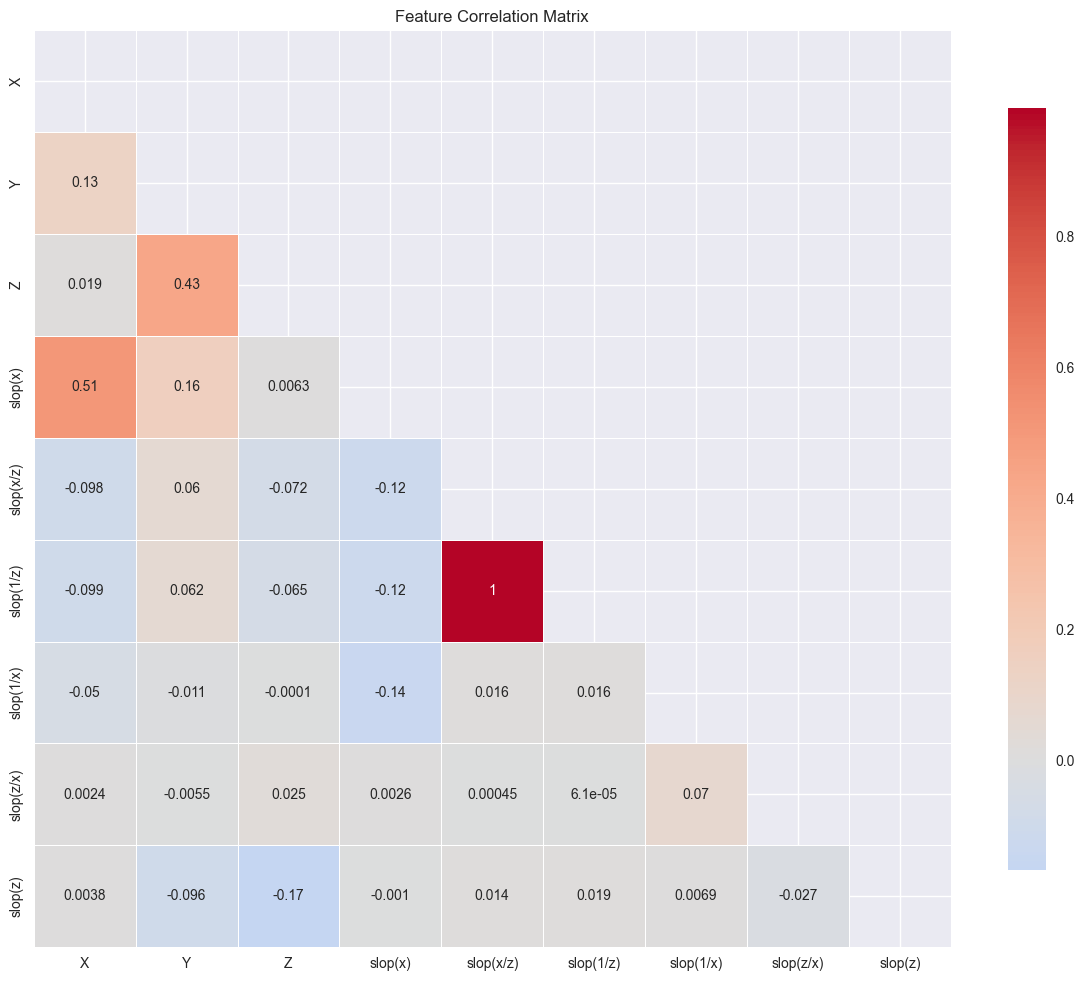

<Figure size 800x550 with 0 Axes>

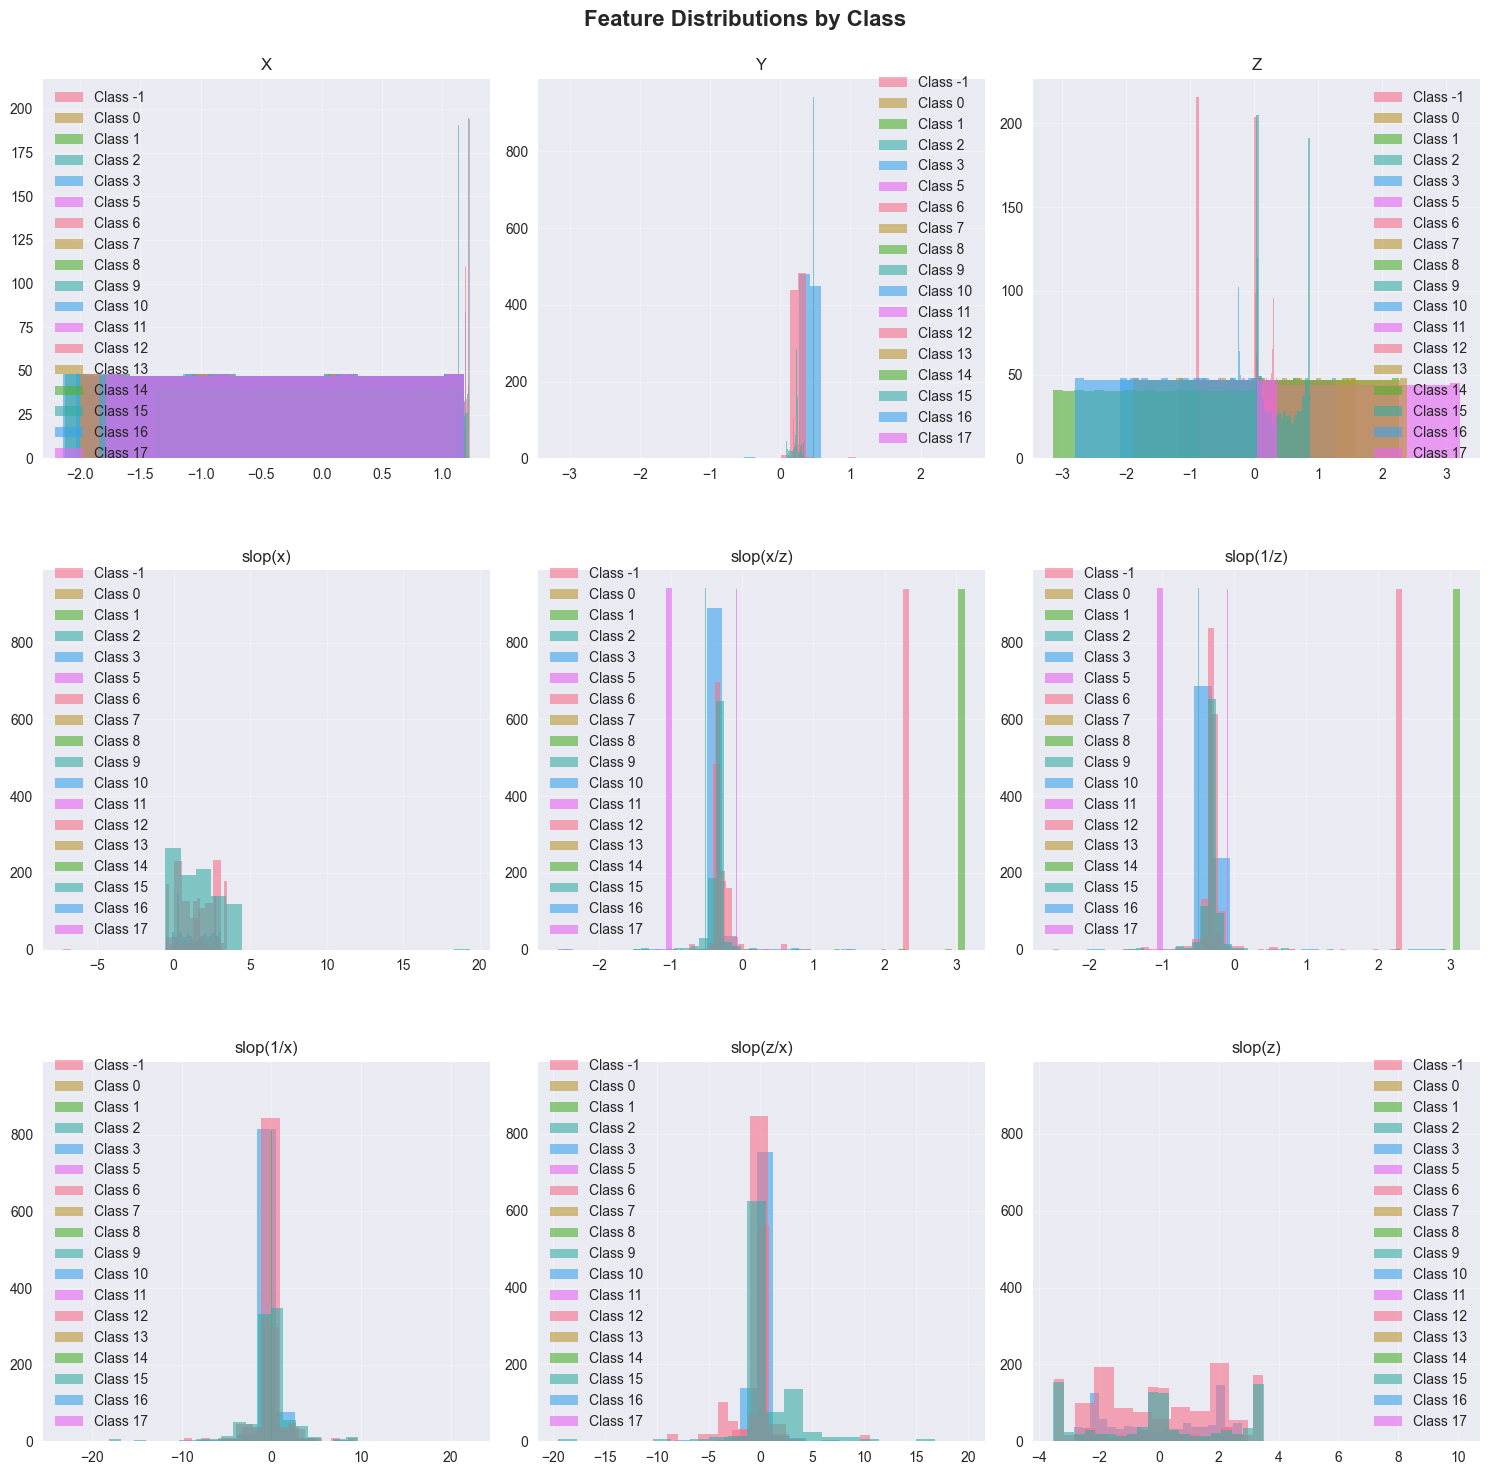

<Figure size 800x550 with 0 Axes>

In [31]:
print("Exploratory Data Analysis")

# Feature correlation heatmap
plt.figure(figsize=(12, 10))
correlation_matrix = X.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0, square=True, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()
plt.savefig('feature_correlation_heatmap.png')

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
fig.suptitle('Feature Distributions by Class', fontsize=16, fontweight='bold')

feature_cols = X.columns[:9]  # Plot first 9 features
for i, feature in enumerate(feature_cols):
    row, col = i // 3, i % 3
    for class_label in sorted(y.unique()):
        class_data = X[y == class_label][feature]
        axes[row, col].hist(class_data, alpha=0.6, label=f'Class {class_label}', bins=20)
    axes[row, col].set_title(f'{feature}')
    axes[row, col].legend()
    axes[row, col].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.savefig('feature_distributions.png')

Model Performance


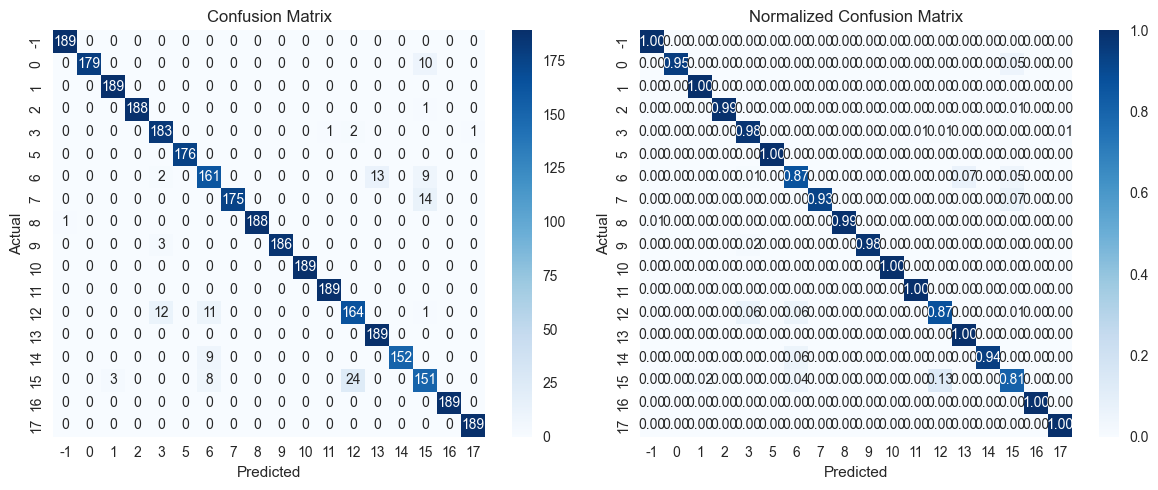

<Figure size 800x550 with 0 Axes>

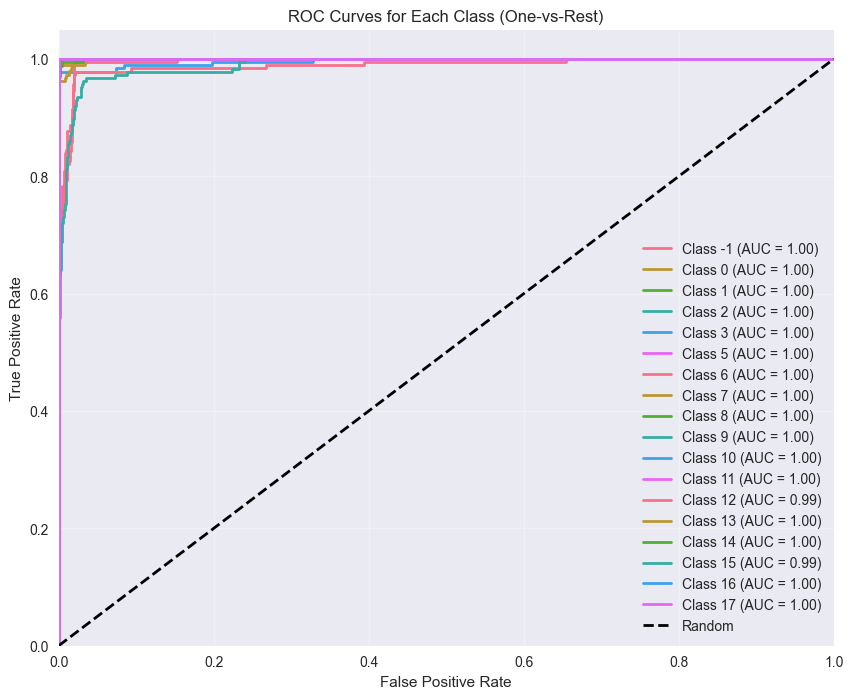

<Figure size 800x550 with 0 Axes>

In [32]:
print("Model Performance")

plt.figure(figsize=(12, 5))

# Confusion Matrix
plt.subplot(1, 2, 1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(y.unique()), yticklabels=sorted(y.unique()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Normalize Confusion Matrix
plt.subplot(1, 2, 2)
cm_normalized = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=sorted(y.unique()), yticklabels=sorted(y.unique()))
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()
plt.savefig('confusion_matrices.png')

# ROC Curves for each class
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

plt.figure(figsize=(10, 8))
classes = sorted(y.unique())
n_classes = len(classes)

y_test_bin = label_binarize(y_test, classes=classes)
if n_classes == 2:
    y_test_bin = np.hstack((1 - y_test_bin, y_test_bin))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {classes[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Class (One-vs-Rest)')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()
plt.savefig('roc_curves.png')

clf = log_reg_pipeline.named_steps["clf"]
feature_names = X.columns

Learning Curves


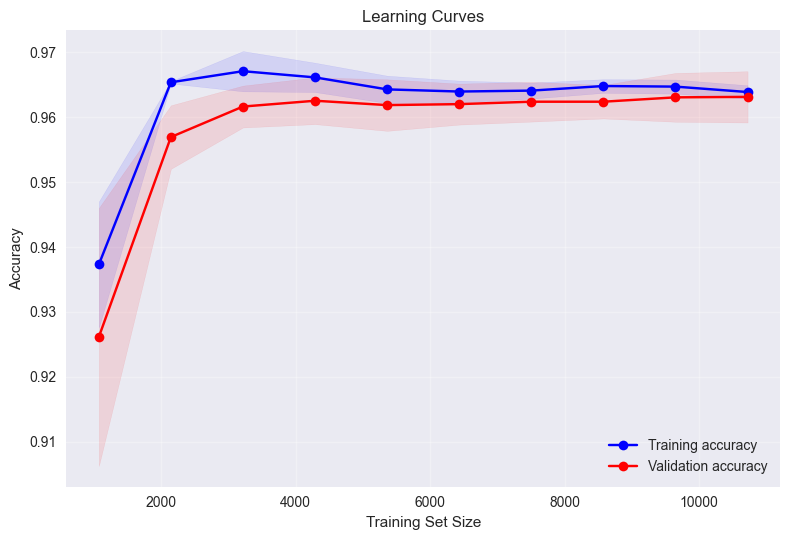

<Figure size 800x550 with 0 Axes>

In [ ]:
print("Learning Curves")

# Learning curves
train_sizes, train_scores_lc, validation_scores_lc = learning_curve(LogisticRegression(C=1.0, solver='lbfgs', max_iter=1000), X_train, y_train, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

plot, ax = plt.subplots(figsize=(10, 6))
plot.plot(train_sizes, np.mean(train_scores_lc, axis=1), 'o-', label='Training accuracy', color='blue')
plot.plot(train_sizes, np.mean(validation_scores_lc, axis=1), 'o-', label='Validation accuracy', color='red')
plot.fill_between(train_sizes, np.mean(train_scores_lc, axis=1) - np.std(train_scores_lc, axis=1), np.mean(train_scores_lc, axis=1) + np.std(train_scores_lc, axis=1), alpha=0.1, color='blue')
plot.fill_between(train_sizes, np.mean(validation_scores_lc, axis=1) - np.std(validation_scores_lc, axis=1), np.mean(validation_scores_lc, axis=1) + np.std(validation_scores_lc, axis=1), alpha=0.1, color='red')
plot.xlabel('Training Set Size')
plot.ylabel('Accuracy')
plot.title('Learning Curves')
plot.legend()
plot.grid(True, alpha=0.3)

plot.tight_layout()
plot.show()
plot.savefig('learning_curves.png')